# Taller 2

1. [**Parámetros del kart obtenidos de documentos de Córdoba y Clavijo**](#primero)
2. [**Funciones auxiliares usadas**](#segundo)
3. [**Implementación de modelo de potencia de Clavijo**](#tercero)
4. [**Desarrllo del modelo para aceleración**](#cuarto)
5. [**Desarrllo del modelo para frenado**](#quinto)
6. [**Predicción de tiempo y distancia recorrida 0-Vmax-0**](#sexto)
7. [**Análisis de desempeño de cada relación**](#septimo)
8. [**Comparación final**](#octavo)
9. [**Conclusiones**](#noveno)
9. [**Referencias**](#decimo)

In [3]:
%pylab inline
from scipy.integrate import odeint
import matplotlib.pyplot as plt
#Importación de librerias de scipy y matplotlib

Populating the interactive namespace from numpy and matplotlib


### Parámetros del kart obtenidos de documentos de Córdoba y Clavijo: <a name="primero"></a>

In [4]:
rho=1.1955 #Densidad del aire
ald=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (si estatura del piloto es de 1.68 m) (m)
Af=ald*alj #Area frontal del kart
Cd=0.89 #Coeficiente de arrastre
eta=0.95 #Eficiencia de la transmisión


Ie=5.2E-3 # Inercia del motor (kg m^2)

#Datos llantas
mfw=1.43 # Masa llantas traseras (kg)
mrw=1.20 # Masa llantas delanteras (kg)
rfw=0.129 # Radio llantas delanteras (m)
rinf=0.0631 # Radio rin llantas delanteras (m)
rrw=0.139 # Radio geométrico de las llantas en traseras (m)
rinr=0.0631 #radio rin llanta trasera (m)
refc=0.98*rrw # Radio efectivo llantas traseras (m)
mbt=0.7*mrw # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mrw # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mfw # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mfw # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
Ifw=(mbd*rfw)+(mdd*(rfw**2-rinf**2))/2 # Inercia 1 llanta delantera (kg-m^2)
Irw=(mbt*rrw)+(mdt*(rrw**2-rinr**2))/2 # Inercia 1 llanta trasera (kg-m^2)

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)
Ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)


# Datos Kart general
masa=152.0 # masa del Kart (kg)
masa_piloto=62 #(kg)
masat=masa+masa_piloto
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)
Tf=17 #Torque al aplicar freno(Nm) 

# Variables de tiempo para aceleración
t_in=0
t_fin=100
deltat=1000
t=linspace(t_in,t_fin,deltat)

# condiciones iniciales de aceleración
x_0=0
v_0=0.01
c_ini=[x_0,v_0]

## Funciones auxiliares usadas <a name="segundo"><a> 

In [110]:
def arrastre(V): #Cálculo de fuerza de arrastre, dependiente de la velocidad.
    Fd=0.5*rho*Af*Cd*V**2
    return Fd

def omega(V,ng): #Cálculo de la velocidad angular. Se límita a 5000 por el motor. Se retorna en RPM.
    w=(V*ng/refc)*60/(2*pi)
    if size(V)>1:
        for i in range(size(V)):
            if w[i]>=5000:
                w[i]=5000
    if size(V)==1:            
        if w>=5000:
            w=5000
    return w

    if size(w)>1:
        for i in range(size(w)):
            if w[i]<50:
                T[i]=14.31775979799432
            if T[i]>38: #limitación de torque máximo del motor
                T[i]=38
    if size(w)==1:
        if T>38:
            T=38

def frodadura_const(V,w):
    fr=0.01*(1+(V/100.0)) # Factor de rodadura. La velocidad del kart debe estar en (km/h)
    return w*2*pi/60*fr # (N)

def ftraccion(T,ng): #cálculo de fuerza de tracción
    return T*ng*eta/refc

def masa_eq_r(Ie,ng): #Cálculo de masa equivalente 
    meq=((Ie*ng**2)+Ieje+Ifw*2+Irw*2)/refc**2
    return meq

def aceleraciongrafica(w,ng): #graficación de aceleración
    v=w*refc/ng*2*pi/60
    frod = frodadura_const(v*3.6,w)
    farr = arrastre(v)
    T=torque(w)
    acel=(ftraccion(T)-frod-farr)/(masa_eq_r(Ie)+masat)
    plt.plot(w,acel)
    plt.xlabel('Velocidad angular (RPM)')
    plt.ylabel('Aceleración (m/s)')
    
    return plt.show() 

def xacel(sol):  #Grafica posición sólo para aceleración. Entra solucion de la ecuacion diferencial
    plt.plot(sol[2], sol[0], 'b')
    plt.xlabel('tiempo (s)')
    plt.ylabel('posición (m)')
    plt.grid()
    p=sol[0]
    plt.show()
    return print('Se recorren %.3f m antes de llegar a la velocidad máxima' %(p[-1]))
    
def vacel(sol):  #Grafica velocidad sólo para aceleración. Entra vector sol mostrado más adelante
    plt.plot(sol[2],sol[1] , 'g')
    plt.xlabel('tiempo (s)')
    plt.ylabel('velocidad (m/s)')
    plt.grid()
    grafica=plt.show()
    v=sol[1]
    t=sol[2]
    return print('La velocidad máxima es %.3f m/s o %.3f km/h en un tiempo de %.3f s' %(v[-1],v[-1]*3.6,t[-1]))
    
def xdes(sol):  #Grafica posición sólo para desaceleración. Se grafica desde la posición donde se llegó a vmax.
    t=linspace(0,size(sol[2]),size(sol[2]))
    plt.plot(t, sol[0], 'b')
    plt.xlabel('tiempo (s)')
    plt.ylabel('posición (m)')
    plt.grid()
    return plt.show()

def vdes(sol):  #Grafica velocidad sólo para desaceleración.
    t=linspace(0,size(sol[2]),size(sol[2]))
    plt.plot(t, sol[1], 'g')
    plt.xlabel('tiempo (s)')
    plt.ylabel('velocidad (m/s)')
    plt.grid()
    plt.show()
    return print('El tiempo total de frenado es de %.3f' %(t[-1]))

## Implementación de modelo de potencia de Clavijo <a name="tercero"></a>

In [111]:
def torque(w): #Le entra velocidad angular en rpm. Se realiza el ajuste a los datos iniciales de torque para no tener discontinuidades
    P=((-0.00000004564538677*w**3)+(0.0001056995459*w**2)
                  +(1.53209191*w))-1.895523696
    T=P/(w*2*pi/60)
    if size(w)>1:
        for i in range(size(w)):
            if w[i]<50:
                T[i]=14.31775979799432
            if T[i]>38: #limitación de torque máximo del motor
                T[i]=38
    if size(w)==1:
        if T>38:
            T=38
    
    return T

## Desarrollo del modelo para aceleración <a name="cuarto"></a>

In [137]:
def aceleracion(y,t,ng):  #Función a ser integrada para obtención de velocidad y posición en aceleración.
    x,v = y
    vel_motor= omega(v,ng)
    frod = frodadura_const(v*3.6,vel_motor)
    farr = arrastre(v)
    T=torque(vel_motor)
    dydt=[v,(ftraccion(T,ng)-frod-farr)/(masa_eq_r(Ie,ng)+masat)]
    return dydt

def acel(v,ng): #Funcion general de aceleración, le entra solución obtenida de velocidad y relación de transmisión
    vel_motor= omega(v,ng)
    frod = frodadura_const(v*3.6,vel_motor)
    farr = arrastre(v)
    T=torque(vel_motor)
    return (ftraccion(T,ng)-frod-farr)/(masa_eq_r(Ie,ng)+masat)

def solacel(t,cini,ng): #Soluciona la ecuacion diferencial de aceleración. Entra tiempo y cond. iniciales.
    sol=odeint(aceleracion,cini,t,args=(ng,))
    for i in range(size(sol[:,1])-1): #con este for se cortan los datos en donde la velocidad máxima se estabiliza.
        if sol[i+1,1]-sol[i,1]<0.0015:
            vel=sol[:,1][sol[:,1]<=sol[i,1]] #vector de velocidades hasta vmax.
            pos=sol[:,0][0:size(vel)] #vector de posiciones hasta donde se alcanza vmax
            tacel=t[0:size(vel)] #tiempo de 0 hasta donde se llega a vmax
            break
    return(pos,vel,tacel)

def graficacel(sol,ng): #Grafica aceleración en función del tiempo
    aceleracion=acel(sol[1],ng)
    plt.plot(sol[2],aceleracion)
    plt.xlabel('tiempo (s)')
    plt.ylabel('Aceleración (m/$s^2$)')
    return plt.show()


## Desarrollo del modelo para frenado <a name="quinto"></a>

In [141]:
def desaceleracion(y,t0,ng):  #Función a ser integrada para obtención de velocidad y posición en desaleración.
    x,v = y
    vel_motor= omega(v,ng)
    frod = frodadura_const(v*3.6,vel_motor)
    farr = arrastre(v)
    T=torque(vel_motor)
    dydt=[v,(-Tf/refc-frod-farr)/(masa_eq_r(Ie,ng)+masat)]
    return dydt

def cinides(sol): #Esta función calcula las condiciones iniciales para desaceleración, a partir de una solución dada de acel.
    v=sol[1]  #velocidad máxima aproximada del kart en m/s. Se obtiene de ultima posicion de la solcución de velocidad en acel.
    v_1=v[-1]
    x=sol[0]
    x_1=x[-1] #Obtención de posición donde se llega a a velocidad máxima.
    c_ini=[x_1,v_1]  # condiciones iniciales para desaceleración.
    return c_ini  

def soldes(t,cini,ng): #Función que soluciona la ecuación diferencial para desaceleración. Entra mismo tiempo usado para acel y cond. in
    t_des=linspace(t[-1],100) #tiempo para el cual se realizará la solución. Inicia en el ultimo tiempo de aceleración (donde se llega a vmax).
    sol=odeint(desaceleracion,cini,t_des,args=(ng,)) #soluciona la ecuación diferencial
    vel_frenado=sol[:,1][sol[:,1]>0] #remoción de velocidades negativas
    pos_frenado=sol[:,0][0:size(vel_frenado)] #remoción de posiciones en donde las velocidades son negativas
    tiempofrenado=t_des[0:size(vel_frenado)] #se corta el vector t_des para que llegue hasta donde vel=0
    return (pos_frenado,vel_frenado,tiempofrenado)

## Predicción de tiempo y distancia recorrida 0-Vmax-0 <a name="sexto"></a>

Teniendo ya los modelos de aceleración y desaceleración, lo que se realiza a continuación es la graficación de los dos segmentos unidos, a partir de lo cual se llega al modelo completo deseado.

In [114]:
def graficaposicion(solucionacel,soluciondes):      #Gráfica de posición completa. Le entra solucion de acel y desacel
    plt.plot(solucionacel[2],solucionacel[0],'b')    # Las columnas 2 de solucionacel y soluciondes corresponden a los tiempos calculados en las funciones solucion
    plt.plot(soluciondes[2],soluciondes[0],'b')
    x=soluciondes[0]
    plt.xlabel('Tiempo (s)')
    plt.ylabel('posición (m)')
    plt.grid()
    plt.show()
    return print('La distancia total recorrida es de %.3f' %(x[-1]))

def graficavelocidad(solucionacel,soluciondes):      #Gráfica de velocidad completa. Aplican parámetros de función anterior
    plt.plot(solucionacel[2],solucionacel[1],'g')    
    plt.plot(soluciondes[2],soluciondes[1],'g')
    t=soluciondes[2]
    plt.xlabel('Tiempo (s)')
    plt.ylabel('velocidad (m/s)')
    plt.grid()
    plt.show()
    return print('El tiempo total del recorrido es de %.3f s' %(t[-1]))

## Análisis de desempeño de cada relación <a name="septimo"></a>

Para el análisis de desempeño, se analizaron las siguientes relaciones de transmisión, incluyendo la relación establecida en el documento de Córdoba:

| Dientes plato | Dientes piñón | Relación de transmisión |
|:-------------:|:-------------:|:-----------------------:|
|       42      |       15      |           2.80          |
|       58      |       12      |           4.83          |
|       78      |       13      |           6.00          |
|       62      |       17      |           3.64          |
|       75      |       10      |           7.50          |

 ### Relación de transmisión de 2.8

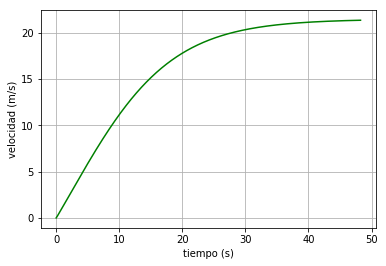

La velocidad máxima es 21.326 m/s o 76.773 km/h en un tiempo de 48.248 s


In [115]:
n1=2.8
acel1=solacel(t,c_ini,n1)
vacel(acel1)

Para este caso, el kart se tarda 48 segundos en llegar a su velocidad máxima. Una vez se realice una comparación con difrentes relaciones de transmisión, será posible determinar si el resultado es eficiente o no. La distancia recorrida con esta relación se observa en la siguiente gráfica:

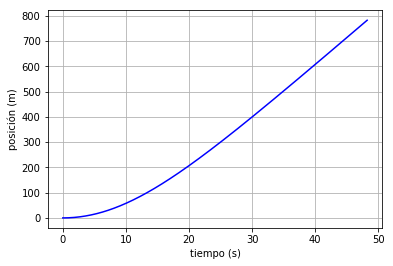

Se recorren 782.427 m antes de llegar a la velocidad máxima


In [116]:
xacel(acel1)

Le toma, entonces, poco más de medio kilómetro para llegar a su velocidad máxima.

Ahora, se soluciona la ecuación de aceleración para frenado. Se usa como conidiciones iniciales la velocidad y posición recién mostradas.

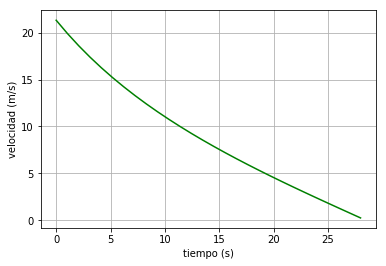

El tiempo total de frenado es de 28.000


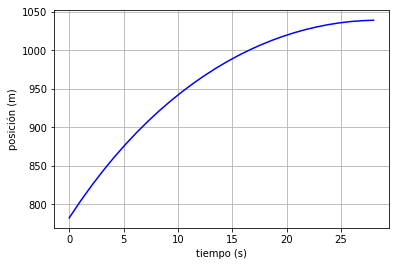

In [117]:
c1=cinides(acel1)
desacel1=soldes(acel1[2],c1,n1)
vdes(desacel1)
xdes(desacel1)

Bajo el modelo utilizado, donde se usa una fuerza de frenado constante que sólo depende del troque negativo aplicado, se tiene que el tiempo de frenado es de 28 s. Ahora, se observa la distancia recorrida bajo esta situación.

A continuación, se observa el modelo completo de 0-Vmax-0.

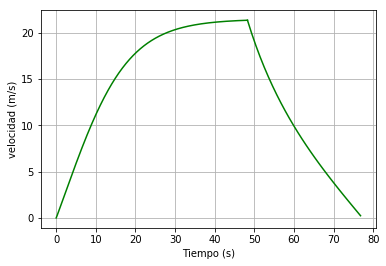

El tiempo total del recorrido es de 76.765 s


In [118]:
graficavelocidad(acel1,desacel1)

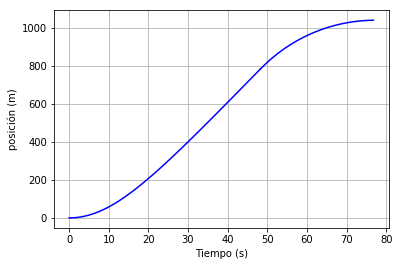

La distancia total recorrida es de 1038.930


In [119]:
graficaposicion(acel1,desacel1)

Se llega a que el total del recorrido desde velocidad 0 hasta velocida máxima, para luego frenar hasta detenerse, tarda 76 segundos, recorriendo una distancia de poco más de 1 kilómetro. 

Una vez realizado este análisis por partes de cada uno de las situaciones (aceleración y desaceleración), se procede a realizar un análisis más general, utlizando las siguientes relaciones de transmisión, obtenidas de Comet Kart sales [1] 

## Relación de transmisión de 4.83

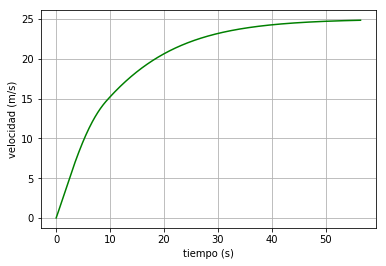

La velocidad máxima es 24.856 m/s o 89.483 km/h en un tiempo de 56.456 s


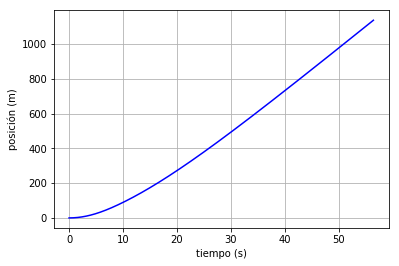

Se recorren 1135.912 m antes de llegar a la velocidad máxima


In [120]:
n2=4.83
acel2=solacel(t,c_ini,n2)
vacel(acel2)
xacel(acel2)

Para esta relación se observa un aumento tanto en la velocidad máxima como en la distancia recorrida para llegar a la misma. Aunque el aumento de la primera es de 13 km/h, el aumento en el recorrido es de casi 400 metros. Se podría decir que este aumento justifica la velocidad máxima obtenida. Esta relación podría ser util en circuitos que presenten largas rectas.

Ahora, observando el comportamiento en frenado:

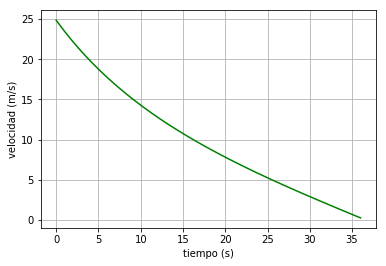

El tiempo total de frenado es de 36.000


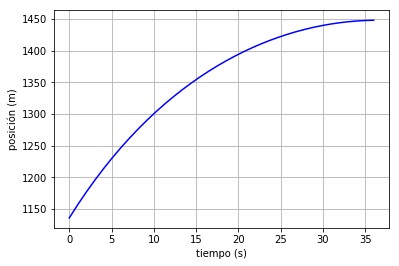

In [121]:
c2=cinides(acel2)
desacel2=soldes(acel2[2],c2,n2)
vdes(desacel2)
xdes(desacel2)

Se observa una reducción en el tiempo de frenado hasta quedar deternido. Para el primer caso, se tiene 28 segundos mientras que, ahora, se reduce por 7 segundos el tiempo. Le toma al kart 350 metros llevar a cabo esta acción, un poco menos del tiempo que le tomaba para la primera relación utilizada.

Ahora, se observa el comportamiento completo del kart:

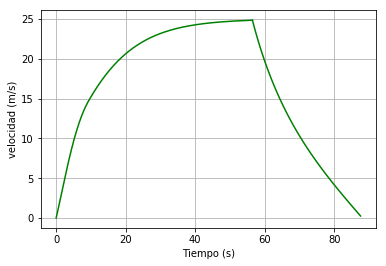

El tiempo total del recorrido es de 87.559 s


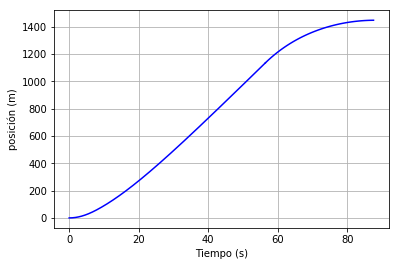

La distancia total recorrida es de 1447.832


In [122]:
graficavelocidad(acel2,desacel2)
graficaposicion(acel2,desacel2)

En comparación con el primer caso, se tiene un aumento de casi 12 segundos con respecto a la relación de transmisión usada por Córdoba. Por otro lado, la distancia que se recorre es de casi un kilómetro y medio, es decir, un aumento de 400 metros, aproximadamente, comparado con el caso anterior.

La ventaja de la relación de transmisión recién analizada es una reducción en el tiempo de frenado. 

### Relación de transmisión de 6.00

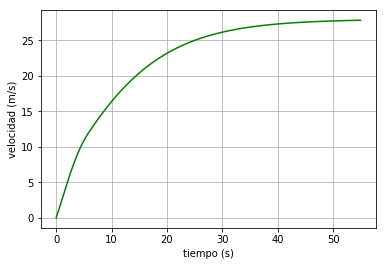

La velocidad máxima es 27.810 m/s o 100.116 km/h en un tiempo de 54.955 s


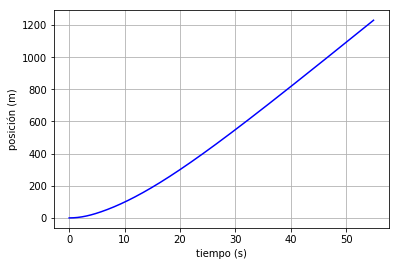

Se recorren 1229.872 m antes de llegar a la velocidad máxima


In [123]:
n3=6
acel3=solacel(t,c_ini,n3)
vacel(acel3)
xacel(acel3)

Si se compara con la relación de 4.83, la velocidad máxima obtenida es 10 km/h más alta. Se puede ver que se aumenta en menor cantidad de lo que se vio la segunda relación con la usada por Córdoba. Le toma al kart casi un minuto llegar a este valor, por lo que ya no se consideraría eficiente el uso de esta relación, sumando a esto el hecho de que la distancia que se recorre es 1.2 km.

Para el caso del frenado:

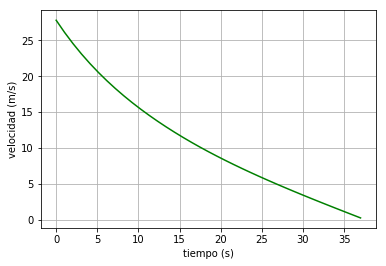

El tiempo total de frenado es de 37.000


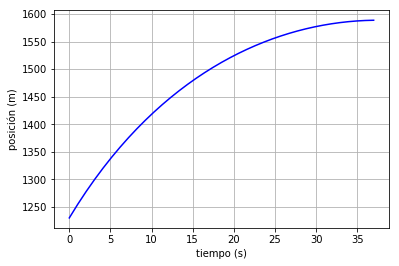

In [124]:
c3=cinides(acel3)
desacel3=soldes(acel3[2],c3,n3)
vdes(desacel3)
xdes(desacel3)

El modelo de torque constante utilizado predice un tiempo de 37 segundos para detenerse, en una distancia de 350 metros. Por su parte, el tiempo de frenado se aumenta en sólo 1 segundo, comparado con el caso anterior. En este sentido, la relación es eficiente.

Observando el desempeño total:

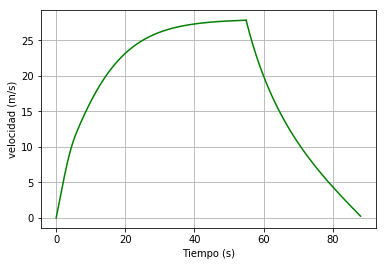

El tiempo total del recorrido es de 88.049 s


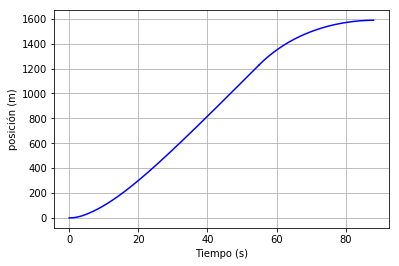

La distancia total recorrida es de 1588.796


In [125]:
a=graficavelocidad(acel3,desacel3)
graficaposicion(acel3,desacel3)

El tiempo total del recorrido se aumenta en un segundo, mientras que la distancia total aumenta en poco más de 130 metros. Aunque se toma más tiempo para alcanzar la velocidad máxima, el tiempo del recorrido completo justficaría el uso de esta relación sobre las anteriores.

### Relación de 3.64

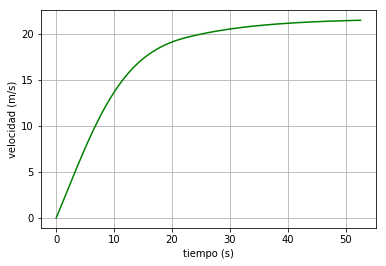

La velocidad máxima es 21.441 m/s o 77.187 km/h en un tiempo de 52.553 s


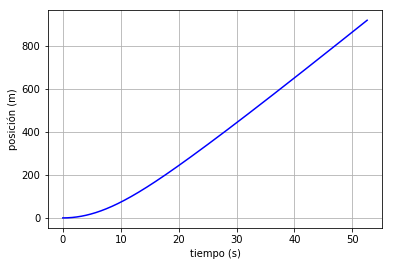

Se recorren 917.553 m antes de llegar a la velocidad máxima


In [126]:
n4=3.64
acel4=solacel(t,c_ini,n4)
vacel(acel4)
xacel(acel4)

La relación usada en este caso supera por 0.8 a la estándar usada por Córdoba. El uso de esta aumenta sólo en 0.1 m/s la velocidad máxima del primer caso. Para subir este valor, le toma al kart 4 segundos. Por esta razón, sería más adecuado el uso de la relación con la que el vehículo ya se encuentra. Además de esto, son casi 200 metros más los que le toma llegar a esta velocidad, otra razón por la cual la relación analizada no es eficiente.

Por su parte, para el frenado:

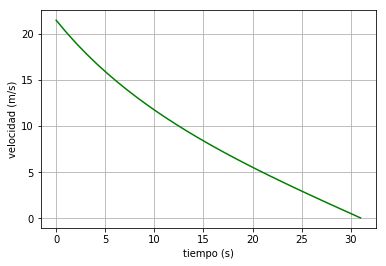

El tiempo total de frenado es de 31.000


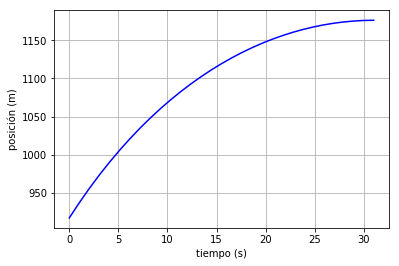

In [127]:
c4=cinides(acel4)
desacel4=soldes(acel4[2],c4,n4)
vdes(desacel4)
xdes(desacel4)

Aunque el desempeño en aceleración no varía significativamente con respecto al primer caso, para el frenado se tiene un aumento de, aproximadamente, 4 segundos con respecto a la relación estándar. Este aumento, en relación con lo obtenido en aceleración, no justificaría el uso de esta relación.

Observando el comportamiento 0-Vmax-0:

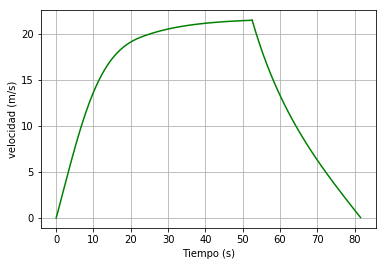

El tiempo total del recorrido es de 81.602 s


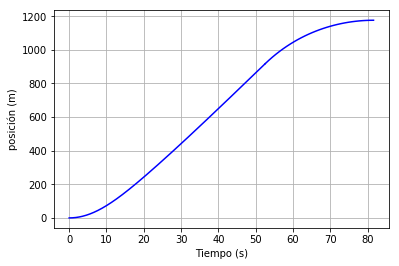

La distancia total recorrida es de 1176.164


In [128]:
b=graficavelocidad(acel4,desacel4)
graficaposicion(acel4,desacel4)

Como se esperaba, se tiene un leve aumento tanto en el tiempo total como en la distancia recorrida (respecto a la transmisión usada por Córdoba). Esta diferencia sería mejor apreciable en un circuito con rectas largas. Sin embargo, para los disponibles (kartódromo de Cajicá y Tocancipá), sería de mejor uso y rendimiento la primera relación usada, hasta el momento.

## Relación de transmisión de 7.5

Finalmente, se analiza la relación de 7.5 obtenida de la referencia ya mostrada.

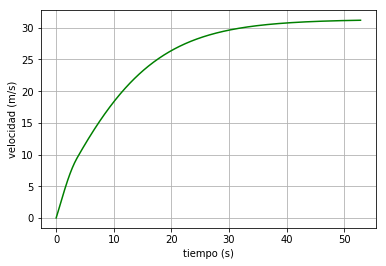

La velocidad máxima es 31.191 m/s o 112.289 km/h en un tiempo de 52.853 s


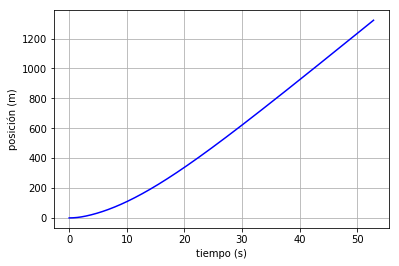

Se recorren 1322.428 m antes de llegar a la velocidad máxima


In [129]:
n5=7.5
acel5=solacel(t,c_ini,n5)
vacel(acel5)
xacel(acel5)

Si se analiza la velocidad máxima obtenida, se ve que esta ya no incrementa más al aumentar la relación de transmisión. Esta no difiere significativamente, comparándola con los casos donde se usan menores relaciones. Sin embargo, la distancia recorrida para llegar se aumenta por 200 metros.

Analizando el caso de frenado:

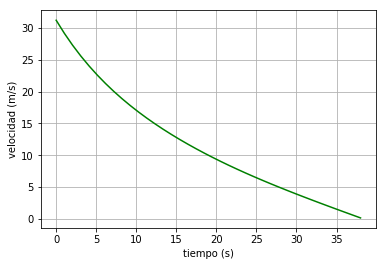

El tiempo total de frenado es de 38.000


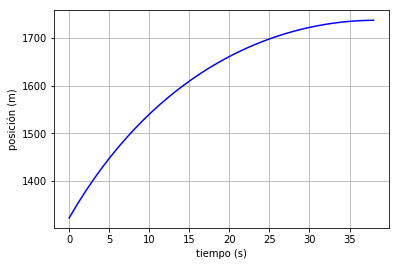

In [130]:
c5=cinides(acel5)
desacel5=soldes(acel5[2],c5,n5)
vdes(desacel5)
xdes(desacel5)

Se observa un leve aumento en el tiempo que tarda en frenar (3 segundos, con respecto al caso base). Se sigue la tendencia mencionada anteriormente, en donde el gran aumento de la relación de transmisión no cambia significativamente el desempeño del kart en recta.

Finalmente, se presenta el resultado completo:

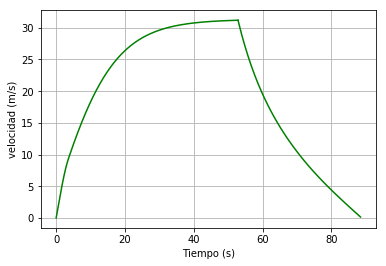

El tiempo total del recorrido es de 88.454 s


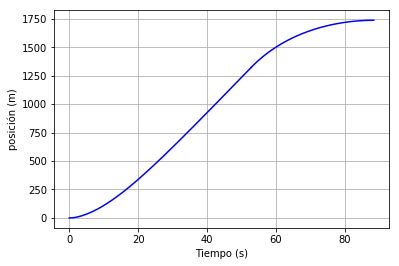

La distancia total recorrida es de 1737.021


In [131]:
graficavelocidad(acel5,desacel5)
graficaposicion(acel5,desacel5)

## Comparación final <a name="octavo"></a>

A continuación se presenta una tabla con un resumen de los resultados obtenidos, junto con graficas finales comparativas

| Relación de transmisión | Velocidad máxima (km/h) | Distancia recorrida 0-Vmax-0 (m) | Tiempo total del recorrido (s) |
|:-----------------------:|:-----------------------:|:--------------------------------:|:------------------------------:|
|           2.8           |          76.77          |              1038.93             |              76.76             |
|           4.83          |          89.48          |              1447.83             |              87.56             |
|           6.00          |          100.12         |              1588.79             |              88.05             |
|           3.64          |          77.18          |              1176.16             |              81.60             |
|           7.5           |          112.28         |              1737.02             |              88.45             |

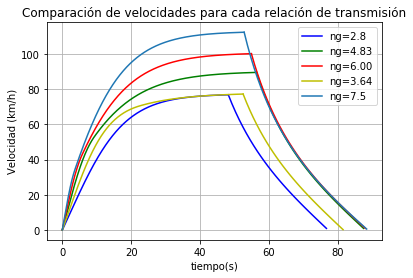

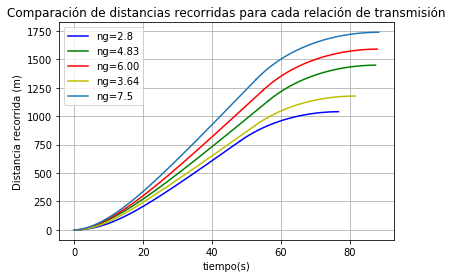

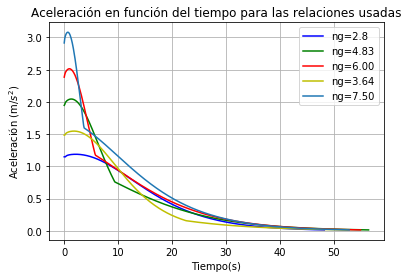

In [147]:
#GRAFICAS DE VELOCIDAD
plt.plot(acel1[2],acel1[1]*3.6,'b',label='ng=2.8')
plt.plot(desacel1[2],desacel1[1]*3.6,'b')

plt.plot(acel2[2],acel2[1]*3.6,'g',label='ng=4.83')
plt.plot(desacel2[2],desacel2[1]*3.6,'g')

plt.plot(acel3[2],acel3[1]*3.6,'r',label='ng=6.00')
plt.plot(desacel3[2],desacel3[1]*3.6,'r')

plt.plot(acel4[2],acel4[1]*3.6,'y',label='ng=3.64')
plt.plot(desacel4[2],desacel4[1]*3.6,'y')

plt.plot(acel5[2],acel5[1]*3.6,'C0',label='ng=7.5')
plt.plot(desacel5[2],desacel5[1]*3.6,'C0')

plt.xlabel('tiempo(s)')
plt.ylabel('Velocidad (km/h)')
plt.legend(loc='best')
plt.grid('on')
plt.title('Comparación de velocidades para cada relación de transmisión')
plt.show()

#GRAFICAS DE POSICION 
plt.plot(acel1[2],acel1[0],'b',label='ng=2.8')
plt.plot(desacel1[2],desacel1[0],'b')

plt.plot(acel2[2],acel2[0],'g',label='ng=4.83')
plt.plot(desacel2[2],desacel2[0],'g')

plt.plot(acel3[2],acel3[0],'r',label='ng=6.00')
plt.plot(desacel3[2],desacel3[0],'r')

plt.plot(acel4[2],acel4[0],'y',label='ng=3.64')
plt.plot(desacel4[2],desacel4[0],'y')

plt.plot(acel5[2],acel5[0],'C0',label='ng=7.5')
plt.plot(desacel5[2],desacel5[0],'C0')

plt.xlabel('tiempo(s)')
plt.ylabel('Distancia recorrida (m)')
plt.legend(loc='best')
plt.grid('on')
plt.title('Comparación de distancias recorridas para cada relación de transmisión')
plt.show()

#GRAFICAS DE ACELERACION
plt.plot(acel1[2],acel(acel1[1],n1),'b',label='ng=2.8')
plt.plot(acel2[2],acel(acel2[1],n2),'g',label='ng=4.83')
plt.plot(acel3[2],acel(acel3[1],n3),'r',label='ng=6.00')
plt.plot(acel4[2],acel(acel4[1],n4),'y',label='ng=3.64')
plt.plot(acel5[2],acel(acel5[1],n5),'C0',label='ng=7.50')
plt.xlabel('Tiempo(s)')
plt.ylabel('Aceleración (m/$s^2$)')
plt.grid('on')
plt.title('Aceleración en función del tiempo para las relaciones usadas')
plt.legend(loc='best')
plt.show()

De la gráfica de velocidad vs. tiempo, se observa que, para las relaciones de 7.5, 6 y 4.83, el comportamiento para el frenado es el mismo, siendo el tiempo total del recorrido similar para las tres, con la diferencia de la velocidad máxima. Además de esto, la velocidad máxima obtenida se alcanza antes para la relación de 7.5, comparada con las relaciones de 6 y 4.83. Por su parte, el comportamiento en aceleración sí varía para todos los casos analizados. Si se comparan las velocidades de la relación original de 2.8 con la de 3.64, se observa que, a pesar de que sus velocidades máximas son similares, para la segunda relación mencionada se alzancan velocidades intermedias mayores en menores tiempos. Por lo tanto, esta sería adecuada para uso en circuitos donde se tengan rectas de cortas longitudes, permitiendo mejorar el rendimiento por vuelta, no mediante una mejor velocidad máxima, sino una mejor aceleración. Sin embargo, habiendo pasado 25 segundos, aproximadamente, las velocidades de cada uno de los casos vuelven a estabiliazrse, presentado de nuevo valores similares.

Si se comparan las relaciones de 7.5 y 3.64, a diferencia de las demás, por medio de estas el kart llega a su velocidad máxima al mismo tiempo. Sin embargo, la ventaja de la segunda es la mejor aceleración ya descrita. 

De la gráfica de distancias recorridas, se aprecia también la similitud entre las distancias recorridas para las relaciones de mayor magnitud usadas. Para cuando se utilizan menores relaciones, se empieza a ver mayor variación en la distancia total recorrida, como es el caso de pasar de una relación de 3.64 a una de 4.83.

Finalmente, se muestra una gráfica en la que se observa el comportamiento de la aceleración para cada relación de transmisión usada. El comportamiento más suave, al iniciar el movimiento, se tiene para la relación de 2.8, en donde no se aprecian cambios abruptos en esta variable. A medida que se aumenta la relación de transmisión, el cambio en la aceleración es más abrupto y, además, una vez transcurridos cinco segundos, aproximadamente, el comportamiento de cada una de las relaciones tiende a ser el mismo. Si se analiza la curva que corresponde a la relación de 3.64, se ve como se alcanza un mínimo de aceleración entre todas las graficas. Esta se ve reflejada en su curva de velocidad, en donde, para el mismo rango de tiempo, la velocidad disminuye, llegando a valores similares a los que se tienen para la relación de 2.8.

## Conclusiones <a name="noveno"></a>

- Las mayores diferencias en rendimiento se observan al utilizar relaciones de transmisión de magnitudes menores a 4, aproximadamente.
- Los tiempos totales de recorrido se establizan una vez se aumenta la magnitud de la relación de transmisión.
- Si se requiere gran aceleración en poco tiempo, se utilziaría una relación similar a la de 3.64.
- Para circuitos con rectas de gran longitud, se recomendaría el uso de una relación como la de 7.5, en donde se alcanza mayor velocidad máxima en un menor tiempo, tardando lo mismo en detenerse que para cuando se usan menores relaciones.

## Referencias <a name="decimo"></a>

[1] <a href="https://cometkartsales.com/skin/comet/images/photos/CometGearChart.pdf">“Gear Ratio Chart,” Comet kart sales. [Online]. Available: https://cometkartsales.com/skin/comet/images/photos/CometGearChart.pdf. [Accessed: 03-Mar-2018].</a>